<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [96]:
%load_ext autoreload
%autoreload 2


import numpy as numpy
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform

import seaborn as sns
import matplotlib.pyplot as plt

from src import soporte_sistemas_recomendacion as sr

import re
import spacy
import contractions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
df = pd.read_csv('datos/datos.csv', index_col=0).reset_index(drop=True)


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewId            10000 non-null  object 
 1   reviewDate          10000 non-null  object 
 2   mainDepartment      10000 non-null  object 
 3   subDepartment       10000 non-null  object 
 4   productName         10000 non-null  object 
 5   reviewTitle         9995 non-null   object 
 6   reviewStar          10000 non-null  float64
 7   reviewText          9999 non-null   object 
 8   inconsistentStatus  10000 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 703.3+ KB


In [99]:
df.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


In [100]:
df.nunique()

reviewId              10000
reviewDate             1487
mainDepartment            5
subDepartment            27
productName              99
reviewTitle            8361
reviewStar                5
reviewText             9928
inconsistentStatus        2
dtype: int64

In [101]:
df.groupby(['mainDepartment', 'subDepartment'])['subDepartment'].count()

mainDepartment            subDepartment                     
Beauty and Personal Care  Foot,Hand & Nail Care                 349
                          Fragrance                             323
                          Hair Care                             372
                          Makeup                                387
                          Shave & Hair Removal                  339
                          Skin Care                             334
Computers                 Computer Accessories & Peripherals    340
                          Computers & Tablets                   336
                          Data Storage                          329
                          Laptop Accessories                    357
                          Men's Accessories                     360
                          Men's Clothing                        341
                          Men's Shoes                           335
                          Men's Watches                

In [102]:
df[df['subDepartment'] == "Men's Watches"]

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
8,R3LYZ7317MLJP0,"Reviewed in the United States on July 19, 2015",Computers,Men's Watches,Invicta Pro Diver Unisex Wrist Watch Stainless...,I like the watch but it had an imperfection un...,2.0,I like the watch. have had it a few days. To...,1
11,R3L7U0UCEM72FI,"Reviewed in the United States on June 20, 2015",Computers,Men's Watches,Fossil Men's Nate Quartz Stainless Steel Chron...,cool to look at but hard to see in the ...,4.0,"Typical Fossil watch, cool to look at but hard...",1
37,R2PXRFTL9MNK0B,"Reviewed in the United States on March 8, 2014",Computers,Men's Watches,Fossil Men's Nate Quartz Stainless Steel Chron...,Great watch! I love it!,3.0,I love it! I give it 5 stars ! One of the nice...,1
63,R1HHRQVB2HEI5R,"Reviewed in the United States on June 28, 2021",Computers,Men's Watches,Invicta Pro Diver Unisex Wrist Watch Stainless...,Smacked the watch snobbery right out of me,5.0,Very impressed.I thought this would be a jangl...,0
137,R3SR6WM00JPNEP,"Reviewed in the United States on March 15, 2017",Computers,Men's Watches,Mens Digital Sports Watch LED Screen Large Fac...,Two Stars,2.0,ok,1
...,...,...,...,...,...,...,...,...,...
9799,RH6MUZMW3WOSI,"Reviewed in the United States on May 1, 2017",Computers,Men's Watches,Fossil Men's Grant Quartz Stainless Steel and ...,One Star,1.0,I'm going to return it watch is not working.,1
9813,R3U56YRZSKI1V5,"Reviewed in the United States on August 26, 2017",Computers,Men's Watches,Mens Digital Sports Watch LED Screen Large Fac...,waste of money,2.0,Bought two of these. Plastic cover very light ...,0
9827,R8W8IMDOGTBUD,"Reviewed in India on December 4, 2017",Computers,Men's Watches,Fossil Men's Grant Quartz Stainless Steel and ...,Not happy😔😔,3.0,Fully disappointed with this product first tim...,1
9829,R2A0T24C9QBXI7,"Reviewed in Canada on May 16, 2018",Computers,Men's Watches,Invicta Pro Diver Unisex Wrist Watch Stainless...,Decent watch but terrible warranty.,3.0,Looks amazing but unfortunately is not covered...,1


Ojo: me doy cuenta que hay algunas subcategorías que no tienen mucha relación con la categoría a la que corresponden. En particular las que pertenecen a ropa y artículos de hombre

In [103]:
df[df.isna().any(axis=1)]

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
4333,R364W01TMAE95T,"Reviewed in the United States on March 25, 2021",Electronics,Video games and accessories,BENGOO G9000 Stereo Gaming Headset for PS4 PC ...,NaN,2.0,"It was clear to hear but speaking for me, no o...",0
6267,R1V4YJT6IDSQ5V,"Reviewed in the United States on December 7, 2020",Beauty and Personal Care,Hair Care,Castor Oil USDA Organic Cold-Pressed (16oz) 10...,NaN,4.0,NaN,1
6488,RD6S1BD3L11QT,"Reviewed in the United States on July 6, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",NaN,1.0,It didn't work as well as we had anticipated.,0
7010,RLCUK197Z6DGX,"Reviewed in the United States on August 4, 2021",Computers,Men's Shoes,Crocs Men's and Women's Classic Clog,NaN,1.0,"This order is not in my possession, yet. Addi...",1
9026,R25QX3HWD0F5SK,"Reviewed in the United States on June 25, 2019",Beauty and Personal Care,Fragrance,"RawChemistry Pheromone Cologne, for Him [Attra...",NaN,3.0,FOR EVERYDAY USE,0


In [104]:
df.dropna(inplace=True)

In [105]:
df.shape

(9995, 9)

In [106]:
df.duplicated().sum()

np.int64(0)

In [107]:
df.describe()

,reviewStar,inconsistentStatus
count,9995.000000,9995.000000
mean,3.003902,0.447824
std,1.410418,0.497295
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,4.000000,1.000000
max,5.000000,1.000000


In [108]:
# stop_words = set(stopwords.words('english'))
# nlp = spacy.load('en_core_web_sm')

In [109]:
# Cargar el modelo de SpaCy fuera de la función para mejorar el rendimiento
def limpiar_texto(texto):

    texto = contractions.fix(texto)
    # Convierte a minúsculas
    texto = texto.lower()
    # Elimina signos de puntuación
    texto = re.sub(r'[.,;]', '', texto)
    # Elimina números
    # texto = re.sub(r'\d+', '', texto)
    # Elimina caracteres especiales
    texto = re.sub(r'[^\w\s]', '', texto)
    # Elimina espacios dobles y saltos de línea
    texto = re.sub(r'\s+', ' ', texto)
    # Quita espacios al inicio y al final
    texto = texto.strip()
    # doc = nlp(texto)
    return texto

df['texto_limpio'] = df['productName'].apply(lambda x: limpiar_texto(x))

# Mostrar las primeras filas
df.head(3)

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus,texto_limpio
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1,doctor developed copper wrist brace carpal tun...
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0,fruit of the loom mens coolzone boxer briefs
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0,tplink ac750 wifi extender re220 covers up to ...


## Sistema de recomendación

In [110]:
# df['columna_combi'] = df['texto_limpio'] + ' ' + df['subDepartment']

In [111]:
vectorize = CountVectorizer(max_features=250, stop_words='english')
vectorize

CountVectorizer(max_features=250, stop_words='english')

In [112]:
#df['columna_combi'].iloc[0]

In [113]:
x = vectorize.fit_transform(df['texto_limpio']).toarray() #tomo para mi modelo a mi columna genres
x

array([[0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [114]:
similarity = cosine_similarity(x)
similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [115]:
def get_index_from_name(name):
    return df[df.productName == name].index[0]

def get_name_from_index(index):
    return df[df.index == index]['productName'].values[0]

In [116]:
user_like_product = df['productName'].sample(n=1).iloc[0] #hago la prueba con este juego

In [117]:
user_like_product

'Invicta Pro Diver Unisex Wrist Watch Stainless Steel Automatic Black Dial - 8926OB'

In [118]:
product_index = get_index_from_name(user_like_product) #busco el indice de mi pelicula
product_index

np.int64(8)

In [119]:
similarity[product_index] #busco la similitud de mi juego elegido con los demás

array([0.26490647, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [120]:
similar_products=list(enumerate(similarity[product_index]))

In [121]:
similar_products[:21]

[(0, np.float64(0.2649064714130088)),
 (1, np.float64(0.0)),
 (2, np.float64(0.0)),
 (3, np.float64(0.0)),
 (4, np.float64(0.0)),
 (5, np.float64(0.0)),
 (6, np.float64(0.2649064714130088)),
 (7, np.float64(0.0)),
 (8, np.float64(1.0000000000000002)),
 (9, np.float64(0.0)),
 (10, np.float64(0.0)),
 (11, np.float64(0.5163977794943223)),
 (12, np.float64(0.0)),
 (13, np.float64(0.0)),
 (14, np.float64(0.0)),
 (15, np.float64(0.0)),
 (16, np.float64(0.18257418583505539)),
 (17, np.float64(0.0)),
 (18, np.float64(0.0)),
 (19, np.float64(0.1924500897298753)),
 (20, np.float64(0.2357022603955159))]

In [122]:
sorted_games =sorted(similar_products, key=lambda x: x[1], reverse=True) #Lo ordenamos para que nos de las pelis que más se parecen a nuestra peli
top_game ={}
for i in sorted_games[1:21]: # le digo que me devuelva las primera 20 pelis sin contar ella misma
    top_game[get_name_from_index(i[0])]=i[1]
    print(i)
top_game

(63, np.float64(1.0000000000000002))
(280, np.float64(1.0000000000000002))
(408, np.float64(1.0000000000000002))
(522, np.float64(1.0000000000000002))
(808, np.float64(1.0000000000000002))
(812, np.float64(1.0000000000000002))
(839, np.float64(1.0000000000000002))
(1310, np.float64(1.0000000000000002))
(1372, np.float64(1.0000000000000002))
(1394, np.float64(1.0000000000000002))
(1885, np.float64(1.0000000000000002))
(2021, np.float64(1.0000000000000002))
(2075, np.float64(1.0000000000000002))
(2336, np.float64(1.0000000000000002))
(2532, np.float64(1.0000000000000002))
(2769, np.float64(1.0000000000000002))
(3148, np.float64(1.0000000000000002))
(3239, np.float64(1.0000000000000002))
(3331, np.float64(1.0000000000000002))
(3580, np.float64(1.0000000000000002))


{'Invicta Pro Diver Unisex Wrist Watch Stainless Steel Automatic Black Dial - 8926OB': np.float64(1.0000000000000002)}

C:\Users\DELL\AppData\Local\Temp\ipykernel_324\1105178153.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


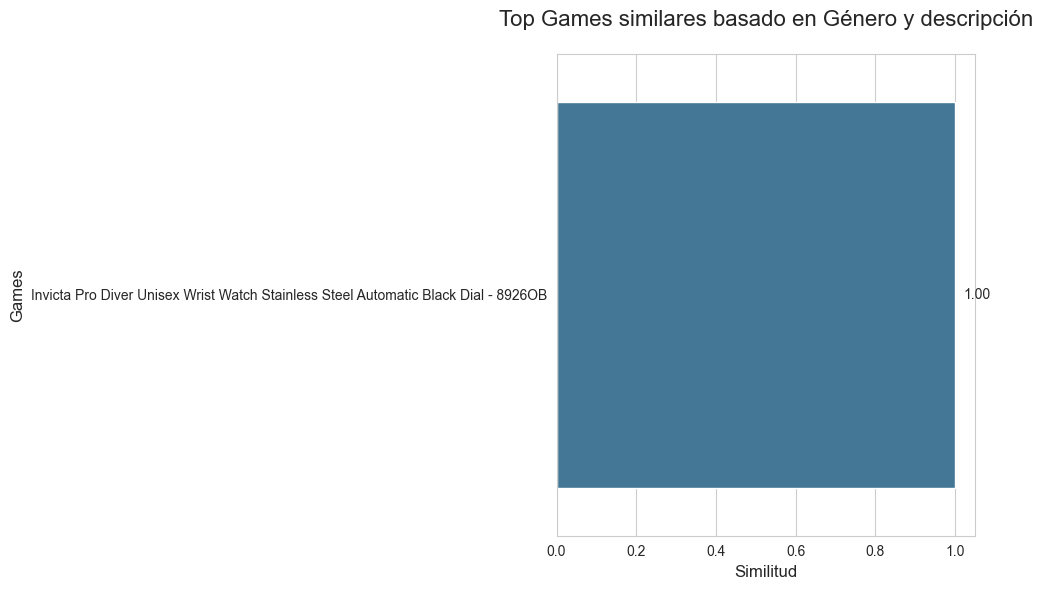

In [123]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    x=list(top_game.values()), 
    y=list(top_game.keys()), 
    palette="mako"
)

plt.title("Top Games similares basado en Género y descripción", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Games", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_game.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()

In [124]:
df['productName'].nunique()

99

Qué ocurre aquí? Al tener un conjunto de datos tan extenso podemos imaginar que tenemos muchos productos, sin embargo tenemos pocos productos a los que se le han realizado muchas reviews. Por ende, cuando buscamos los productos más relacionados los primeros en salir en realidad son la repetición del mismo producto pero en relación a otro review. Por ende, agrupé por los productos únicos

## DF Agrupado

In [125]:
df_agrupado = df.groupby("productName")[['mainDepartment', 'subDepartment', 'texto_limpio', 'reviewStar', 'reviewText']].agg(Departamento=('mainDepartment', 'first'), SubDepartamento=("subDepartment","first"),Producto=("texto_limpio","first"),Star=("reviewStar","mean"),Reseña=('reviewText', ''.join))

In [126]:
df_agrupado.head()

,Departamento,SubDepartamento,Producto,Star,Reseña
productName,,,,,
"(Refurbished) Apple iPhone 7, 32GB, Black - Fully Unlocked",Electronics,CellPhones and Accessories,refurbished apple iphone 7 32gb black fully un...,2.912000,I’ll admit I was very skeptical from reviews b...
"AIMEILI Gel Nail Polish No Wipe Top and Base Coat Set, Shine Finish and Long Lasting, Soak Off Gel Nail Lacquer - 2 x 10ml",Beauty and Personal Care,"Foot,Hand & Nail Care",aimeili gel nail polish no wipe top and base c...,3.077419,"It’s thick, but works good once you get used t..."
AKASO EK7000 4K30FPS Action Camera Ultra HD Underwater Camera 170 Degree Wide Angle 98FT Waterproof Camera,Electronics,Camera and Accessories,akaso ek7000 4k30fps action camera ultra hd un...,2.855932,I was not impressed with the image quality. A...
"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD Display, Intel Celeron N4020 Processor, 4GB RAM, 64GB Storage, NumberPad, Windows 10 Home in S Mode with One Year of Microsoft 365 Personal, L210MA-DB01",Computers,Computers & Tablets,asus laptop l210 ultra thin laptop 116 hd disp...,3.049180,The laptop arrived just in time for school!! W...
"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6"" Full HD IPS | AMD Ryzen 3 3350U Quad-Core Mobile Processor | 4GB DDR4 | 128GB NVMe SSD | WiFi 6 | Backlit KB | Amazon Alexa | Windows 10 Home (S mode)",Computers,Computers & Tablets,acer aspire 5 a51546r14k slim laptop 156 full ...,2.932331,Bought for school work. Doing good so far.Slee...


In [127]:
df_agrupado.reset_index(inplace=True)

In [128]:
df_agrupado['Reseña'].iloc[0]

'I’ll admit I was very skeptical from reviews but I decided to purchase anyways…. and so far so good! Battery life is about 7 hours of constant use (games, videos, etc). Sounds is good. I had no problems connecting to internet. The border of the phone did appear to have some scratches but not too many.The phone I received has a loose charging port that should have been replaced. It was at 27% just now and I plugged it in and opened an app. Now it just gave me the under 20% notification so it’s obviously struggling to keep the cord in place.No working well can\'t download any apps horrible phone My old Android works better than this junk. Please refund money. Diana ManueleIt’s for personal and the battery life issues is crazy it’s only take 2 hoursWorked slow, barely charged.Battery life is not good at all. Only last an hour.The worse I never bought. Battery is dead and I sent it in Africa, so no way to return it. Just lost my money. I could give 0 starI’m very picky with my phone cases

In [129]:
vectorize = CountVectorizer(max_features=250, stop_words='english')
vectorize

CountVectorizer(max_features=250, stop_words='english')

In [130]:
df_agrupado.head()

,productName,Departamento,SubDepartamento,Producto,Star,Reseña
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",Electronics,CellPhones and Accessories,refurbished apple iphone 7 32gb black fully un...,2.912000,I’ll admit I was very skeptical from reviews b...
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,Beauty and Personal Care,"Foot,Hand & Nail Care",aimeili gel nail polish no wipe top and base c...,3.077419,"It’s thick, but works good once you get used t..."
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,Electronics,Camera and Accessories,akaso ek7000 4k30fps action camera ultra hd un...,2.855932,I was not impressed with the image quality. A...
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",Computers,Computers & Tablets,asus laptop l210 ultra thin laptop 116 hd disp...,3.049180,The laptop arrived just in time for school!! W...
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Computers,Computers & Tablets,acer aspire 5 a51546r14k slim laptop 156 full ...,2.932331,Bought for school work. Doing good so far.Slee...


In [131]:
x = vectorize.fit_transform(df_agrupado['Reseña']).toarray() #tomo como consideración las reseñas
x

array([[4, 7, 3, ..., 0, 4, 1],
       [2, 3, 2, ..., 0, 0, 2],
       [1, 7, 2, ..., 2, 3, 1],
       ...,
       [1, 2, 4, ..., 0, 2, 0],
       [2, 2, 4, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 5, 1]])

In [132]:
similarity = cosine_similarity(x)
similarity

array([[1.        , 0.34101339, 0.42052769, ..., 0.39304609, 0.33326915,
        0.32821221],
       [0.34101339, 1.        , 0.50545414, ..., 0.55940093, 0.55992451,
        0.46157884],
       [0.42052769, 0.50545414, 1.        , ..., 0.55114882, 0.4240625 ,
        0.36782472],
       ...,
       [0.39304609, 0.55940093, 0.55114882, ..., 1.        , 0.62648326,
        0.40955782],
       [0.33326915, 0.55992451, 0.4240625 , ..., 0.62648326, 1.        ,
        0.41977328],
       [0.32821221, 0.46157884, 0.36782472, ..., 0.40955782, 0.41977328,
        1.        ]])

In [133]:
def get_index_from_name(name):
    return df_agrupado[df_agrupado.productName == name].index[0]

def get_name_from_index(index):
    return df_agrupado[df_agrupado.index == index]['productName'].values[0]

In [143]:
user_like_product = df_agrupado['productName'].sample(n=1).iloc[0] #elijo un producto al azar

In [144]:
user_like_product

'Android 10.0 Tablet : MEBERRY 10" Ultra-Fast 4GB/RAM,64GB/ROM Tablets-8000mAh Battery-WiFi Support - Bluetooth Keyboard | Mouse | M7 Tablet Cover and More Include - Grey'

In [145]:
game_index = get_index_from_name(user_like_product) #busco el indice de mi pelicula
game_index

np.int64(8)

In [146]:
similarity[game_index] #busco la similitud de mi juego elegido con los demás

array([0.22391727, 0.16506979, 0.21938296, 0.28567596, 0.21441202,
       0.13697953, 0.11551584, 0.19666846, 1.        , 0.12048862,
       0.20498471, 0.17256774, 0.14215418, 0.13097873, 0.10380755,
       0.0974658 , 0.10148463, 0.12995066, 0.12755406, 0.13155684,
       0.09827611, 0.09241259, 0.12439444, 0.22711941, 0.20667261,
       0.24651478, 0.21739212, 0.29565493, 0.14429672, 0.11948349,
       0.14484967, 0.23898874, 0.        , 0.23117342, 0.10285802,
       0.13399317, 0.12134523, 0.13805414, 0.21048097, 0.06946235,
       0.07160663, 0.14846724, 0.10755209, 0.19511998, 0.1308305 ,
       0.0792118 , 0.11263848, 0.3141754 , 0.12687833, 0.08084521,
       0.28774681, 0.16236837, 0.19993185, 0.30813101, 0.21908836,
       0.12935233, 0.15992326, 0.18356699, 0.1792675 , 0.1250714 ,
       0.14151801, 0.2028794 , 0.08015243, 0.11199112, 0.12448601,
       0.22088081, 0.12515931, 0.18107149, 0.27088364, 0.20710218,
       0.09334178, 0.19373377, 0.20004138, 0.21461096, 0.04503

In [147]:
similar_games=list(enumerate(similarity[game_index]))

In [148]:
similar_games[:21]

[(0, np.float64(0.22391727089965208)),
 (1, np.float64(0.16506979013857395)),
 (2, np.float64(0.21938296376625638)),
 (3, np.float64(0.28567596023927666)),
 (4, np.float64(0.21441201689439116)),
 (5, np.float64(0.13697953436682325)),
 (6, np.float64(0.11551584230445212)),
 (7, np.float64(0.1966684649166388)),
 (8, np.float64(1.0)),
 (9, np.float64(0.12048861524966681)),
 (10, np.float64(0.20498470759779966)),
 (11, np.float64(0.17256774216909848)),
 (12, np.float64(0.1421541787399725)),
 (13, np.float64(0.13097872635626956)),
 (14, np.float64(0.10380754895442258)),
 (15, np.float64(0.09746580463862176)),
 (16, np.float64(0.10148462503137323)),
 (17, np.float64(0.12995066066685756)),
 (18, np.float64(0.12755405688074134)),
 (19, np.float64(0.1315568426597344)),
 (20, np.float64(0.09827611301840408))]

In [149]:
sorted_games =sorted(similar_games, key=lambda x: x[1], reverse=True) #Lo ordenamos para que nos de las pelis que más se parecen a nuestra peli
top_game ={}
for i in sorted_games[1:11]: # le digo que me devuelva las primera 20 pelis sin contar ella misma
    top_game[get_name_from_index(i[0])]=i[1]
    print(i)
top_game

(47, np.float64(0.31417540202975736))
(53, np.float64(0.3081310128395198))
(27, np.float64(0.29565493217051136))
(50, np.float64(0.28774681053662243))
(3, np.float64(0.28567596023927666))
(68, np.float64(0.2708836404884793))
(25, np.float64(0.24651477716653494))
(31, np.float64(0.2389887357227246))
(81, np.float64(0.23802707050998778))
(33, np.float64(0.23117341832232147))


{'Lenovo Chromebook Flex 3 11" Laptop, 11.6-Inch HD (1366 x 768) IPS Display, MediaTek MT8173C Processor, 4GB LPDDR3, 64 GB eMMC, Chrome OS, 82HG0006US, Blizzard White': np.float64(0.31417540202975736),
 'Master Lock 8143D Bike Lock Cable with Combination': np.float64(0.3081310128395198),
 'Fitbit Charge 4 Fitness and Activity Tracker with Built-in GPS, Heart Rate, Sleep & Swim Tracking, Black/Black, One Size (S &L Bands Included)': np.float64(0.29565493217051136),
 'MOSISO Compatible with MacBook Air 13 inch Case 2020 2019 2018 Release A2337 M1 A2179 A1932 Retina Display Touch ID, Plastic Hard Shell&Keyboard Cover&Screen Protector&Storage Bag, Transparent': np.float64(0.28774681053662243),
 'ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD Display, Intel Celeron N4020 Processor, 4GB RAM, 64GB Storage, NumberPad, Windows 10 Home in S Mode with One Year of Microsoft 365 Personal, L210MA-DB01': np.float64(0.28567596023927666),
 'Redragon S101 Wired Gaming Keyboard and Mouse Combo RGB Backlit

C:\Users\DELL\AppData\Local\Temp\ipykernel_324\1105178153.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DELL\AppData\Local\Temp\ipykernel_324\1105178153.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


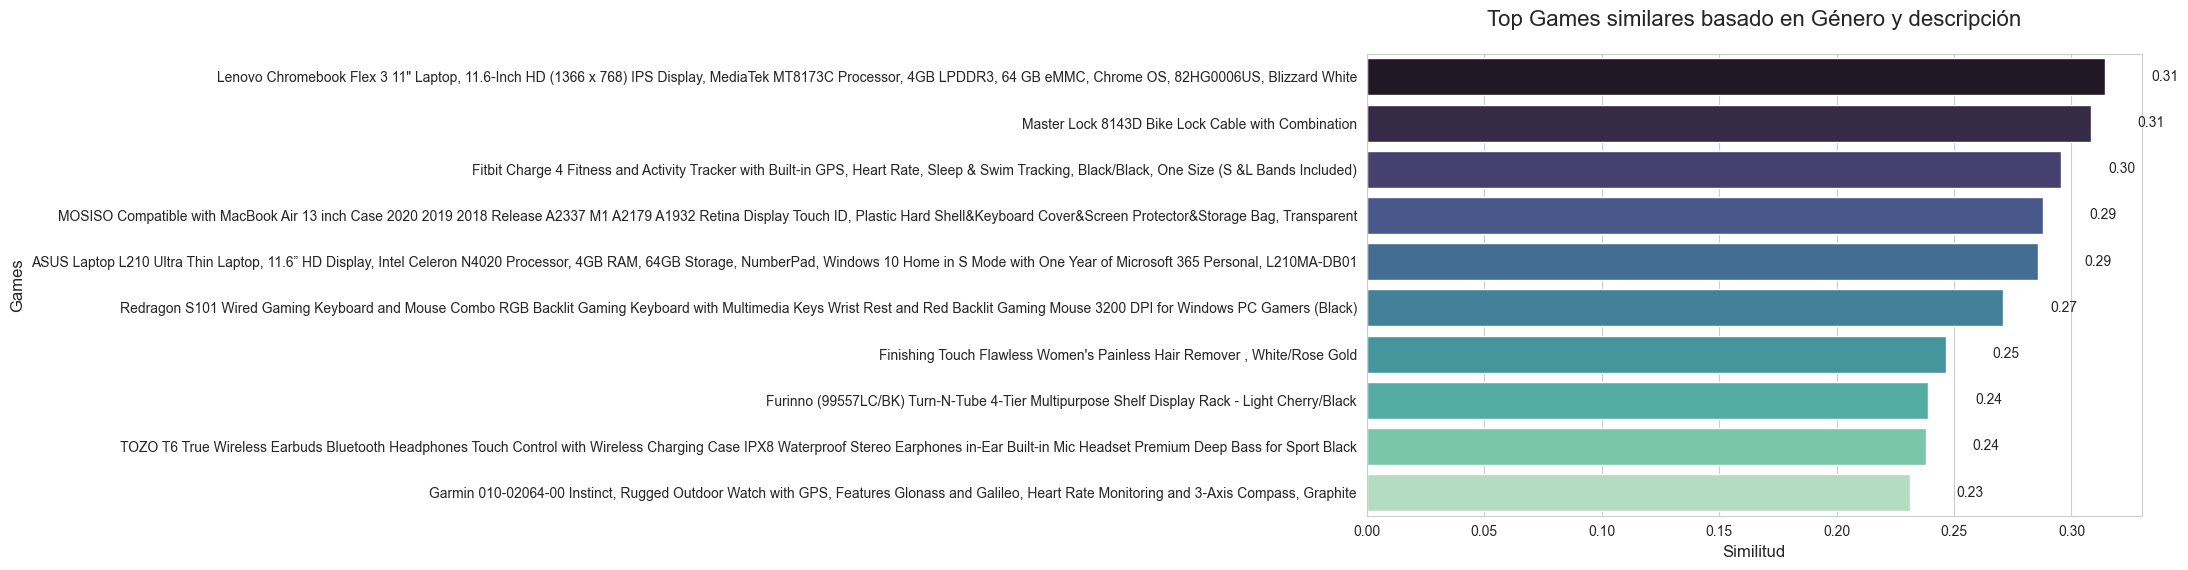

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    x=list(top_game.values()), 
    y=list(top_game.keys()), 
    palette="mako"
)

plt.title("Top Games similares basado en reseñasdescripción", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Games", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_game.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()

En nuestra visualización, nos damos cuenta de artículos tecnológicos relacionados a nuestra última elección. Las relaciones no son extremadamente fuertes, pero los artículos hacen sentido considerando la SubCategoría a la que pertenecen.